Correlation between Inflation and Yields: 1.00
Correlation between Monetary Policy and Yields: 1.00


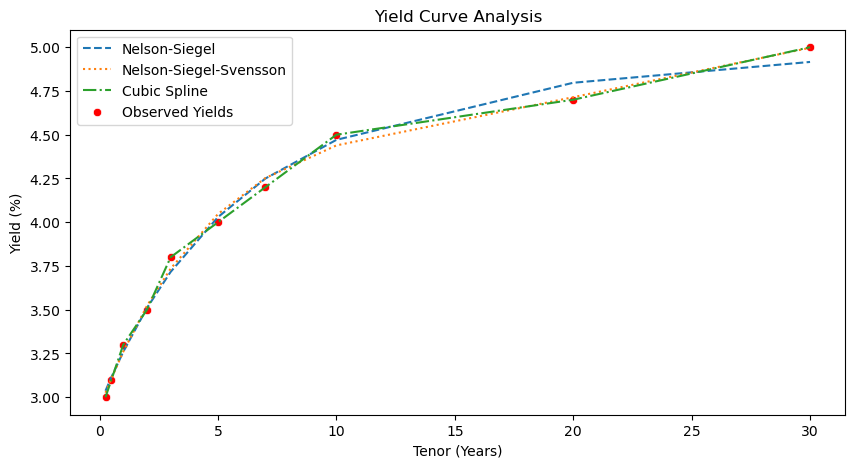

Macaulay Duration: 7.98 years


<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Backtrader Performance Visualization')

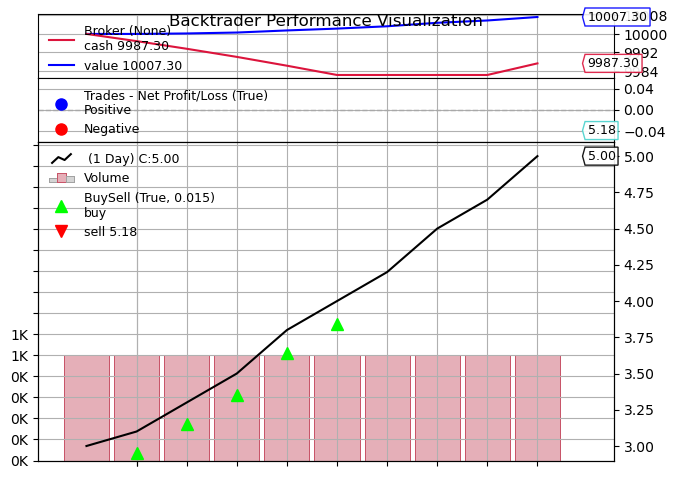

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import backtrader as bt

# Generate synthetic bond yield data (tenors in years, yields in %)
tenors = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([3.0, 3.1, 3.3, 3.5, 3.8, 4.0, 4.2, 4.5, 4.7, 5.0])

# Nelson-Siegel Model Definition
def nelson_siegel(t, beta0, beta1, beta2, tau):
    return beta0 + beta1 * ((1 - np.exp(-t/tau)) / (t/tau)) + beta2 * (((1 - np.exp(-t/tau)) / (t/tau)) - np.exp(-t/tau))

# Nelson-Siegel-Svensson Model Definition
def nelson_siegel_svensson(t, beta0, beta1, beta2, beta3, tau1, tau2):
    return (beta0 + beta1 * ((1 - np.exp(-t/tau1)) / (t/tau1)) + 
            beta2 * (((1 - np.exp(-t/tau1)) / (t/tau1)) - np.exp(-t/tau1)) +
            beta3 * (((1 - np.exp(-t/tau2)) / (t/tau2)) - np.exp(-t/tau2)))

# Fit Nelson-Siegel Curve
params_ns, _ = curve_fit(nelson_siegel, tenors, yields, p0=[3, -1, 1, 2])
fitted_ns_yields = nelson_siegel(tenors, *params_ns)

# Fit Nelson-Siegel-Svensson Curve
params_nss, _ = curve_fit(nelson_siegel_svensson, tenors, yields, p0=[3, -1, 1, -0.5, 2, 5])
fitted_nss_yields = nelson_siegel_svensson(tenors, *params_nss)

# Cubic Spline Interpolation
cs = CubicSpline(tenors, yields)
cs_yields = cs(tenors)

# Macroeconomic Variables
inflation_rates = np.array([2.1, 2.2, 2.5, 2.8, 3.0, 3.2, 3.5, 3.8, 4.0, 4.2])  # Example inflation data
monetary_policy_rates = np.array([2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75])  # Central bank policy rates

# Analyze the correlation between macroeconomic variables and yield curve
correlation_inflation_yield = np.corrcoef(inflation_rates, yields)[0, 1]
correlation_policy_yield = np.corrcoef(monetary_policy_rates, yields)[0, 1]

print(f"Correlation between Inflation and Yields: {correlation_inflation_yield:.2f}")
print(f"Correlation between Monetary Policy and Yields: {correlation_policy_yield:.2f}")

# Plot Yield Curves
plt.figure(figsize=(10, 5))
sns.lineplot(x=tenors, y=fitted_ns_yields, label='Nelson-Siegel', linestyle='--')
sns.lineplot(x=tenors, y=fitted_nss_yields, label='Nelson-Siegel-Svensson', linestyle=':')
sns.lineplot(x=tenors, y=cs_yields, label='Cubic Spline', linestyle='-.')
sns.scatterplot(x=tenors, y=yields, color='red', label='Observed Yields')
plt.xlabel("Tenor (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve Analysis")
plt.legend()
plt.show()  # Show the figure instead of saving it

# Forward Rate Calculation (using finite differences)
forward_rates = np.diff(yields) / np.diff(tenors)

# Zero-Coupon Yield Calculation (Bootstrapping)
def bootstrap_zero_coupon(yields, tenors):
    zero_rates = []
    for i in range(len(tenors)):
        zero_rate = ((1 + yields[i] / 100) ** tenors[i] - 1) / tenors[i]
        zero_rates.append(zero_rate * 100)
    return np.array(zero_rates)

zero_coupon_yields = bootstrap_zero_coupon(yields, tenors)

# Duration Calculation (Macaulay Duration)
def macaulay_duration(cashflows, yields, tenors):
    discounted_cf = cashflows / (1 + yields / 100) ** tenors
    return np.sum(discounted_cf * tenors) / np.sum(discounted_cf)

duration = macaulay_duration(np.array([100, 100, 100, 1100]), np.array([3.5, 3.8, 4.2, 5.0]), np.array([1, 3, 5, 10]))
print(f"Macaulay Duration: {duration:.2f} years")

# Backtesting a Fixed-Income Portfolio
class BondStrategy(bt.Strategy):
    def next(self):
        if self.data.close[0] < 4.0:  # Simple rule: Buy when yield < 4%
            self.buy()
        elif self.data.close[0] > 4.5:  # Sell when yield > 4.5%
            self.sell()

# Ensure DataFrame is properly formatted
df = pd.DataFrame({'close': yields}, index=pd.date_range(start='2024-01-01', periods=len(yields), freq='ME'))
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN
df.dropna(inplace=True)  # Drop NaN values
df.sort_index(inplace=True)  # Ensure index is sorted
df["open"] = df["close"]  # Add an open price column
df["high"] = df["close"] + 0.1  # Simulated high prices
df["low"] = df["close"] - 0.1  # Simulated low prices
df["volume"] = 1000  # Dummy volume

data = bt.feeds.PandasData(dataname=df)
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(BondStrategy)
cerebro.run()

# Display Backtrader Plot with Title
fig = plt.figure(figsize=(10, 5))
plt.title("Backtrader Performance Visualization")
plt.xlabel("Time")
plt.ylabel("Portfolio Value / Metrics")
cerebro.plot(numfigs=1)[0][0].suptitle("Backtrader Performance Visualization")
